<a href="https://colab.research.google.com/github/zhus-dika/computer_vision_home_works/blob/main/cars_recognition_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/cars-recognition-competition'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## https://www.kaggle.com/competitions/hse-cars-competition/overview

## Import need packages

In [2]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torchvision
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import PIL
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from imgaug import augmenters as iaa

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Extracting data

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/MyDrive/hse/comp_vision/data/'

labels = pd.read_csv(data_path + 'annotation/train_ann.csv')

labels.sample(7)

,imname,class
4621,train/9121bbcc34dcf9e953fca2befafa38cd.jpg,27
4985,train/02b3b24286201f3da1f5b8341a7d7cf9.jpg,103
4065,train/0c2a9872dd3d1df9f1bf687d08847bc9.jpg,125
503,train/a5138426c28fc1e43272583501470f80.jpg,184
1653,train/67d12e0f790f34a15ae7638d09e1ff9a.jpg,118
2935,train/200dcbfff52e5682086e8b5ecd9bfcd4.jpg,191
7223,train/66fb15d72b4cae924c0aaf6fd1fbdfde.jpg,179


In [6]:
with open('/content/drive/MyDrive/hse/comp_vision/data/annotation/class_names.txt') as f:
    lines = f.readlines()

In [7]:
class_names = lines[0].strip('\n').split(',')

In [8]:
# ! cp -r /content/drive/MyDrive/hse/comp_vision/data/images/train ./train
# ! cp -r /content/drive/MyDrive/hse/comp_vision/data/images/test ./test

In [9]:
#images_path = '/content/drive/MyDrive/hse/comp_vision/data/images/'
images_path = './'

## Prepare Dataset

In [10]:
class OurDataset(data.Dataset): #отпочковались
  """Our dataset class.

    Arguments:
        root (str): path to images
        imlist - pandas DataFrame with columns file_name, class
        transform - torchvision transform applied to every image
    """
  def __init__(self, root, flist, transform=None):
        self.root   = root
        self.imlist = flist #в нашем случае это будет датафрейм
        self.transform = transform

  def __getitem__(self, index):
        #берем строку из пришедшего df по index
        impath, target = self.imlist.loc[index]

        #собираем полное имя картинки
        full_imname = os.path.join(self.root, impath)

        if not os.path.exists(full_imname): #если нет такой, ругаемся
            print('No file ', full_imname)
            pass

        #Сразу используем PIL тк torchvision.transforms работает с PIL Image (https://pytorch.org/docs/stable/torchvision/transforms.html)
        img = Image.open(full_imname).convert('RGB')

        #применяем к изображению выбранное преобразование (аугментацию)
        img = self.transform(img)

        #на выход отдаём img, target - нужны для обучения и валидации
        return img, target, impath

  #метод возвращает длину датасета - просто как длину подаваемого dataframe
  def __len__(self):
        return len(self.imlist)

In [11]:
#готовим всё для подачи в OurDataset и заведение DataLoader

#преобразование для train и val пока одинаковое
train_transforms = torchvision.transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandAugment(magnitude=12),
        transforms.ToTensor(),
        transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
    ])
# transforms.RandAugment()
# transforms.AugMix()
# https://github.com/aleju/imgaug?tab=readme-ov-file#documentation
# seq = iaa.Sequential([iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0,3.0))),
#                       iaa.Sometimes(0.5,iaa.LinearContrast((0.75,1.5))),
#                       iaa.AdditiveGaussianNoise(loc=0,scale=(0.0,0.05*255),per_channel=0.5),
#                       iaa.ChangeColorTemperature((1100, 10000), from_colorspace='RGB'),
#                       iaa.Sometimes(0.5,iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)))],random_order=True)
# seq = iaa.Sequential([iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0,3.0))),
#                       iaa.Sometimes(0.5,iaa.LinearContrast((0.75,1.5))),
#                       iaa.AdditiveGaussianNoise(loc=0,scale=(0.0,0.05*255),per_channel=0.5),
#                       iaa.Sometimes(0.5,iaa.Affine(
#         scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
#         translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
#         rotate=(-25, 25),
#         shear=(-8, 8)))],random_order=True)

# train_transforms = torchvision.transforms.Compose([
#         transforms.Resize((224,224)),
#         iaa.Sequential([
#           iaa.flip.Fliplr(p=0.5),
#           iaa.flip.Flipud(p=0.5),
#           iaa.GaussianBlur(sigma=(0.0, 0.1)),
#           iaa.MultiplyBrightness(mul=(0.65, 1.35)),
#         ]).augment_image,
#         transforms.ToTensor(),
#         transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
#     ])

valid_transforms = torchvision.transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
    ])

#датафреймы
train, val = train_test_split(labels, test_size=0.05, random_state=777)

#нам нужно будет обращаться по индексу, так что делаем reset
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

batch_size=32

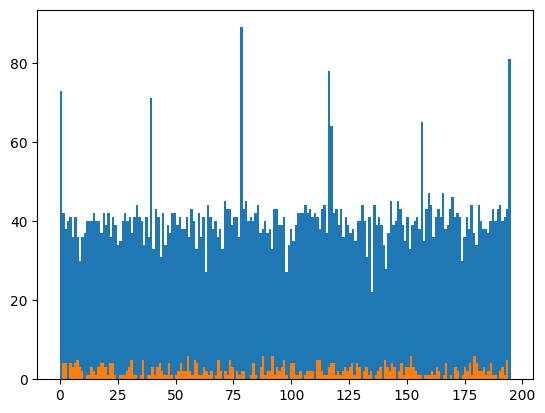

In [12]:
import matplotlib.pyplot as plt

plt.hist(train['class'], bins=190);
plt.hist(val['class'], bins=190);

In [13]:
train_dataset = OurDataset(root=images_path, flist=train, transform=train_transforms)
valid_dataset = OurDataset(root=images_path, flist=val, transform=valid_transforms)

num_gpus = torch.cuda.device_count()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2*num_gpus, pin_memory=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2*num_gpus, pin_memory=True)

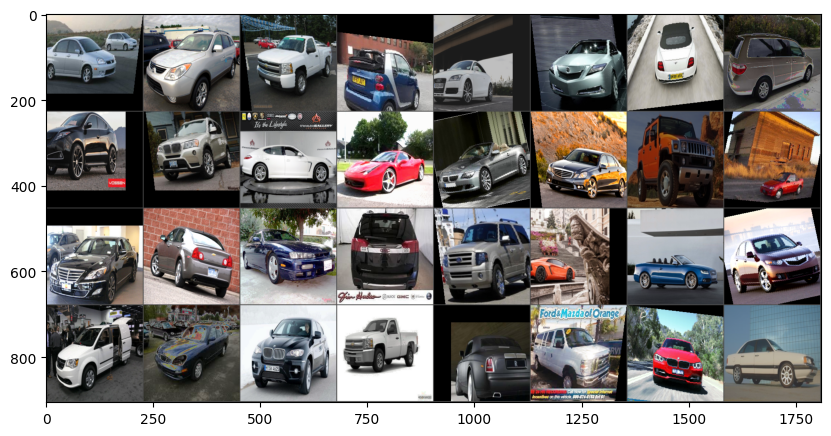

In [14]:
def myshow(img):
    img = img * 0.3 + 0.3 #умножаем на std, прибавляем mean - в Normalize всё наоборот
    npimg = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0))

trainiter = iter(train_dataloader)
images, labels, impaths = next(trainiter)
myshow(torchvision.utils.make_grid(images))

In [15]:
print(images.shape)
print(labels)
print(impaths)

torch.Size([32, 3, 224, 224])
tensor([180, 132,  74, 195,  18,   6,  38, 126,   6,  36, 172, 103,  35, 163,
        123, 122, 136,  66, 170, 117, 108, 150,  20,   4, 173,  81,  32,  68,
        176, 115,  28,  16])
['train/325ed251e093a108c1de99fd54c17ebc.jpg', 'train/641cb9fd65c43ee95f52f73ab0b896e2.jpg', 'train/4e0d0652777d5764b8471d973d9af1b0.jpg', 'train/947bf37226e2e9d57aaf6300b5a70198.jpg', 'train/e6b82421ddfa77991f9ee7366f5b6a06.jpg', 'train/2700ae97275cc94c5c1739548f27b715.jpg', 'train/b0b79dc68e6f8b5442bf16e61a3436bd.jpg', 'train/c34b8160b76a742c7ea9ee12c23815ae.jpg', 'train/069cb2095c0d94e82dc086e53e10c86e.jpg', 'train/5c0720184df207a1b1a7cf3718a13fbb.jpg', 'train/4992fbe67f70c59c18efe780d07228e1.jpg', 'train/5bd0927ae56cde1487fdf4aa6f8ec2fa.jpg', 'train/0d704d05db107aedadba8107dfaa66ac.jpg', 'train/bc2c866fc97d5fc791c132cfcf022af4.jpg', 'train/e27b421cc2faca02fdd2f20c63efefdc.jpg', 'train/9f38f9e5c8a8d20ca265c9ca19004617.jpg', 'train/7628357d42fd98be3df85d6f0b277622.jpg', 't

## ResNext101

In [16]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.2 MB/s eta 0:00:00


https://huggingface.co/timm

https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055#5e2d

https://github.com/facebookresearch/pycls/blob/main/MODEL_ZOO.md

In [17]:
import timm


def get_net():
    #model = timm.create_model('regnety_320.pycls_in1k', pretrained=True, num_classes=196)
    model = timm.create_model('regnetx_320.pycls_in1k', pretrained=True, num_classes=196)
    #pycls.models.regnetx("16.0GF", pretrained=True)
    #resnet = models.resnext101_32x8d(pretrained=True)
    #resnext50_32x4d
    #resnext101_32x8d
    #resnext101_64x4d

    # Substitute the FC output layer
    #model.fc = torch.nn.Linear(model.fc.in_features, 196)
    #torch.nn.init.xavier_uniform_(model.fc.weight)
    return model

In [18]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for data in train_dataloader:
            X, y, _= data
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for data in valid_dataloader:
                    X, y, _= data
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')

        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

https://www.kaggle.com/code/dinarazhussupova/96-fine-tuning-resnet34-with-pytorch/edit

## Training

In [21]:
lr, weight_decay, epochs = 1e-5, 1e-3, 40

net = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
#params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
#optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=int(len(train_dataset)/batch_size + 1)*epochs)

net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, epochs, device)

Training for 40 epochs on cuda
Epoch 1/40
Training loss: 5.21
Training accuracy: 2.83
Valid loss: 5.09
Valid accuracy: 8.85

Epoch 2/40
Training loss: 4.71
Training accuracy: 17.68
Valid loss: 4.33
Valid accuracy: 21.62

Epoch 3/40
Training loss: 3.95
Training accuracy: 29.62
Valid loss: 3.40
Valid accuracy: 38.57

Epoch 4/40
Training loss: 3.13
Training accuracy: 42.58
Valid loss: 2.64
Valid accuracy: 50.61

Epoch 5/40
Training loss: 2.41
Training accuracy: 56.82
Valid loss: 1.91
Valid accuracy: 61.43

Epoch 6/40
Training loss: 1.80
Training accuracy: 68.89
Valid loss: 1.44
Valid accuracy: 70.02

Epoch 7/40
Training loss: 1.35
Training accuracy: 77.02
Valid loss: 1.09
Valid accuracy: 76.41

Epoch 8/40
Training loss: 0.98
Training accuracy: 83.79
Valid loss: 0.88
Valid accuracy: 80.10

Epoch 9/40
Training loss: 0.73
Training accuracy: 87.96
Valid loss: 0.72
Valid accuracy: 80.84

Epoch 10/40
Training loss: 0.55
Training accuracy: 91.09
Valid loss: 0.62
Valid accuracy: 82.31

Epoch 11/4

Experiments:

--------

1. **batch_size** = 156

model=resnet50

**lr, weight_decay, epochs** = 1e-5, 5e-4, 100

transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.IMAGENET)

test_acc = 0.0056

--------
2. **batch_size** = 64

model=resnet50

**lr, weight_decay, epochs** = 1e-5, 5e-4, 40

transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.IMAGENET)

test_acc = 0.0056

--------

3. **batch_size** = 64

model=resnet101

**lr, weight_decay, epochs** = 1e-5, 5e-4, 40

transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.IMAGENET)

test_acc = 0.00715

--------
4. **batch_size** = 64

model=resnext50_32x4d

**lr, weight_decay, epochs** = 1e-5, 5e-4, 40

transforms.RandAugment()

--------

5. **batch_size** = 64

model=resnext50_32x4d

**lr, weight_decay, epochs** = 1e-4, 5e-4, 10

transforms.RandAugment()

--------

6. **batch_size** = 64

model=resnext101_32x4d

**lr, weight_decay, epochs** = 1e-4, 5e-3, 20

transforms.RandAugment()

test_acc = 0.826

--------

7. **batch_size** = 128

model=resnext101_32x4d

**lr, weight_decay, epochs** = 1e-4, 5e-3, 20

transforms.RandAugment()

--------

8. **batch_size** = 32

model=resnext101_32x4d

**lr, weight_decay, epochs** = 1e-5, 1e-2, 20

transforms.RandAugment()

test_acc = 0.88

--------

9. **batch_size** = 32

model=resnet101

**lr, weight_decay, epochs** = 1e-4, 5e-3, 20

transforms.RandAugment()

test_acc =

--------

10. **batch_size** = 32

model=resnext101

**lr, weight_decay, epochs** = 5e-6, 1e-3, 40

transforms.RandAugment()

test_acc = 0.85

--------

11. **batch_size** = 32

model=regnetx_160.pycls_in1k

**lr, weight_decay, epochs** = 5e-6, 1e-3, 50

transforms.RandAugment()

test_acc = 86.98

--------

11. **batch_size** = 32

model=regnetx_320.pycls_in1k

**lr, weight_decay, epochs** = 5e-6, 1e-3, 50

transforms.RandAugment()

test_acc =

--------




## Saving & Loading Model for Inference

In [22]:
filename = '/content/drive/MyDrive/hse/comp_vision/models/net.pth'

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, filename)


save_model(epochs, net, optimizer, criterion)

## Check via test_annotated

In [23]:
paths = []
data_path = '/content/drive/MyDrive/hse/comp_vision/data/images/test_annotated'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        paths.append(filename)

In [24]:
len(paths)

118

In [25]:
valid_transforms = torchvision.transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3, 0.3, 0.3], [0.3, 0.3, 0.3])
    ])

In [26]:
test_dataset = torchvision.datasets.ImageFolder(data_path, transform=valid_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [27]:
def class_name2label(class_name):
  for i, name in enumerate(class_names):
    if name == class_name:
      return i

In [28]:
preds = []
test_classes = []

net.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.cpu().numpy()
        test_classes.extend(y)

        preds.extend(net(X).argmax(dim=1).type(torch.int32).cpu().numpy())

In [29]:
set(test_dataset.classes) - set(class_names)

set()

In [30]:
real_classes = []

for i in test_classes:
  real_classes.append(class_name2label(test_dataset.classes[i]))

In [31]:
test_accuracy = 0

for i, pred in enumerate(preds):
  if real_classes[i] == pred:
    test_accuracy += 1

test_accuracy /= len(preds)
print('test_accuracy:', test_accuracy * 100, '%')

test_accuracy: 80.50847457627118 %


## Inference https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/

In [32]:
# initialize the model and load the trained weights
# filename = '/content/drive/MyDrive/hse/comp_vision/models/net_resnext101.pth'

# net = get_net().to(device)
# checkpoint = torch.load(filename, map_location=device)
# net.load_state_dict(checkpoint['model_state_dict'])
# net.eval()

In [33]:
paths = []
data_path = './test'#'/content/drive/MyDrive/hse/comp_vision/data/images/test'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        paths.append(os.path.join('test', filename))

In [34]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.3, 0.3, 0.3],
        std=[0.3, 0.3, 0.3]
    )
])

In [35]:
from tqdm.notebook import tqdm
import cv2

preds = []

for input in tqdm(paths):
  image = cv2.imread(data_path + '/' + input[5:])
  # convert to RGB format
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = transform(image)
  # add batch dimension
  image = torch.unsqueeze(image, 0)
  with torch.no_grad():
      outputs = net(image.to(device))
  output_label = torch.topk(outputs, 1)
  pred_class = output_label.indices[0].cpu().numpy()[0]
  preds.append(pred_class)

  0%|          | 0/8033 [00:00<?, ?it/s]

In [36]:
df = pd.DataFrame({'new_name': paths, 'class': preds})
df.to_csv('/content/drive/MyDrive/hse/comp_vision/submission.csv', index=False)